# Bow-Tie

In this toy model, we will show how LinkNodeCommunity works in simple directed, sparse networks with two clusters bonded by a single node. This is an expected topology for nodes with overlapping community memberships (NOC). 

First, let's import some libraries.

In [1]:
# Standard Python libs ----
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as linknode
from src.LinkNodeCommunity.utils import linknode_equivalence_partition
from src.LinkNodeCommunity.utils import cut_tree_with_validation, collapsed_partition
from src.viz.graphics import graph_network_covers


The make_toys function, as its name suggests, creates the networks that we are going to use in this example. It produces 12 networks, but we will just cover four: toy_0, toy_6, toy_3, and toy_1. As it can be read in the code, the networks with several nodes have a basic layout with two main clusters with strong connections. There is also node A which can have six out of the twelve connections with two different strengths. The algorithm places the six connections in a sequence.

In [2]:
def make_toys():
  ww = 1
  ws = 5

  toy = np.array(
    [
      [0, -1, -1, -1, -1, -1, -1],
      [-1, 0, ws, ws, 0, 0, 0],
      [-1, 0, 0, ws, 0, 0, 0],
      [-1 ,ws ,0, 0, 0, 0 ,0],
      [-1, 0, 0, 0, 0, ws, ws],
      [-1, 0, 0, 0, ws, 0, 0],
      [-1, 0, 0, 0, ws, ws, 0]
    ]
  )
  A = np.array(
    [
      ww, ww, ww,
      ws, ws, ws,
      0, 0, 0,
      0, 0, 0
    ]
  )
  n = 12
  x = np.arange(n)
  NETS = []
  rows, cols = np.where(toy == -1)
  for i in np.arange(n):
    wheel = np.zeros(n)
    wheel[i:] = x[:(n-i)]
    wheel[:i] = x[(n-i):]
    wheel = wheel.astype(int)
    toy_copy = toy.copy()
    toy_copy[rows, cols] = A[wheel]
    NETS.append(
     toy_copy
    )
  return n, NETS


Here, we set up the code to run the link communities, compute the quality functions, and extract the node hierarchy, as usual.

In [3]:
n, NETS = make_toys()
original_labels = np.array(["A", "B", "C", "D", "E", "F", "G"])

labels_dict = dict()
for i in np.arange(7):
  labels_dict[i] = original_labels[i]
toy_labels = {i: original_labels[i] for i in np.arange(len(original_labels))}

clustering = []
for i, net in enumerate(NETS):
  g = nx.from_numpy_array(net, create_using=nx.DiGraph)
  model = linknode.Clustering(g, similarity_index="cosine_similarity", consider_subgraph=False)
  model.add_labels(toy_labels)
  model.fit_linksim_matrix(use_parallel=False, flat_mode=True)
  model.linkdist_matrix = model.linksim_condense_matrix.copy()
  model.linkdist_matrix = 1 - model.linkdist_matrix
  link_hierarchy_statistic = model.process_features_matrix()
  model.node_community_hierarchy_matrix(use_parallel=False)
  clustering.append([g, model, link_hierarchy_statistic])

Adding remaining node communities due to topological constraints.
Adding remaining node communities due to topological constraints.


In this network, node A has only outlinks. In the first plot, we see the link communities colored in the adjacency matrix. The matrix was arranged using the node dendrogram. The second plot shows that nodes BCD and EFG are forming two clusters. Node A, which is not colored, was left behind, and as it is seen in the dendrogram (third), it is clustered only once the other two communities are merged. In the last plot, we can see the link membership of the network and notice how the links from A belong to the two groups.

/Users/jmrtnza/Documents/Documents - Jorge’s MacBook Air/Work/Research/LINKPROJECT/LinkNodeCommunity/.venv/lib/python3.12/site-packages/networkx/drawing/layout.py:982: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)
/Users/jmrtnza/Documents/Documents - Jorge’s MacBook Air/Work/Research/LINKPROJECT/LinkNodeCommunity/.venv/lib/python3.12/site-packages/networkx/drawing/layout.py:1008: RuntimeWarning: invalid value encountered in subtract
  grad = np.einsum("ij,ij,ijk->ik", invdist, offset, direction) - np.einsum(


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

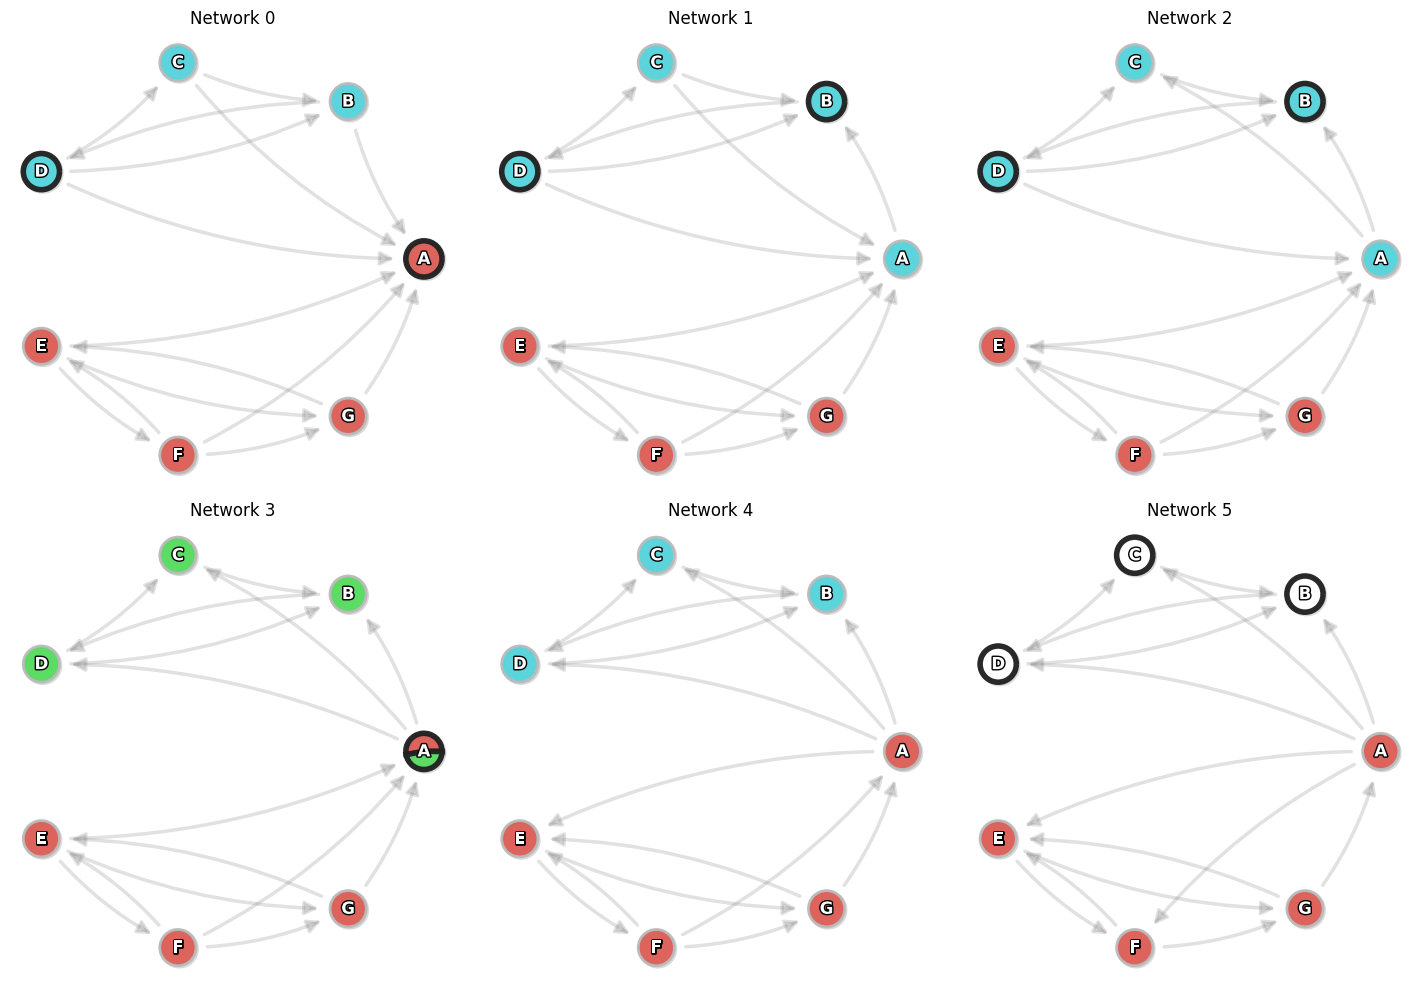

In [4]:
score = "D"

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6):
    number_link_communities, \
        number_node_communities, \
            height_at_maximum = linknode_equivalence_partition(
                score=score,
                link_stats=clustering[idx][2],
                linknode_equivalence=clustering[idx][1].linknode_equivalence
            )

    node_partition = cut_tree_with_validation(clustering[idx][1].Z, number_node_communities)
    node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0

    # NOTE: Node labels as a numpy array
    node_labels = np.array([clustering[0][1].G.nodes[n]["label"] \
                            for n in sorted(clustering[0][1].G.nodes())]
                                )

    # Compute NOCs using the node partition
    nocs_model = linknode.NOCFinder(
        clustering[idx][0], node_partition,
        undirected=False,
        labels=node_labels,
        similarity_index="cosine_similarity",
        tie_policy="include_equal"
    )

    # Fit the NOC model using the precomputed link similarity matrices
    nocs_model.fit(
        clustering[idx][1].linksim.source_sim_matrix,
        clustering[idx][1].linksim.target_sim_matrix
    )

    # Create a copy of the graph with transformed edge weights
    Gdist = clustering[idx][0].copy()
    weights = [d['weight'] for u, v, d in Gdist.edges(data=True)]
    max_weight = max(weights) if weights else 1
    for u, v, d in Gdist.edges(data=True):
        d['weight'] = 1 - d['weight'] / max_weight

    pos = nx.kamada_kawai_layout(Gdist)

    # Plot on the corresponding axis
    graph_network_covers(
        clustering[idx][0],
        pos,
        nocs_model.node_cover_partition,
        node_partition,
        nocs_model.single_node_cover_map,
        nocs_model.single_nodes_cover_scores,
        node_labels,
        figsize=(5, 5),
        scale=0.5,
        ax=axes[idx]
    )
    axes[idx].set_title(f"Network {idx}")

plt.tight_layout()
plt.show()



<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

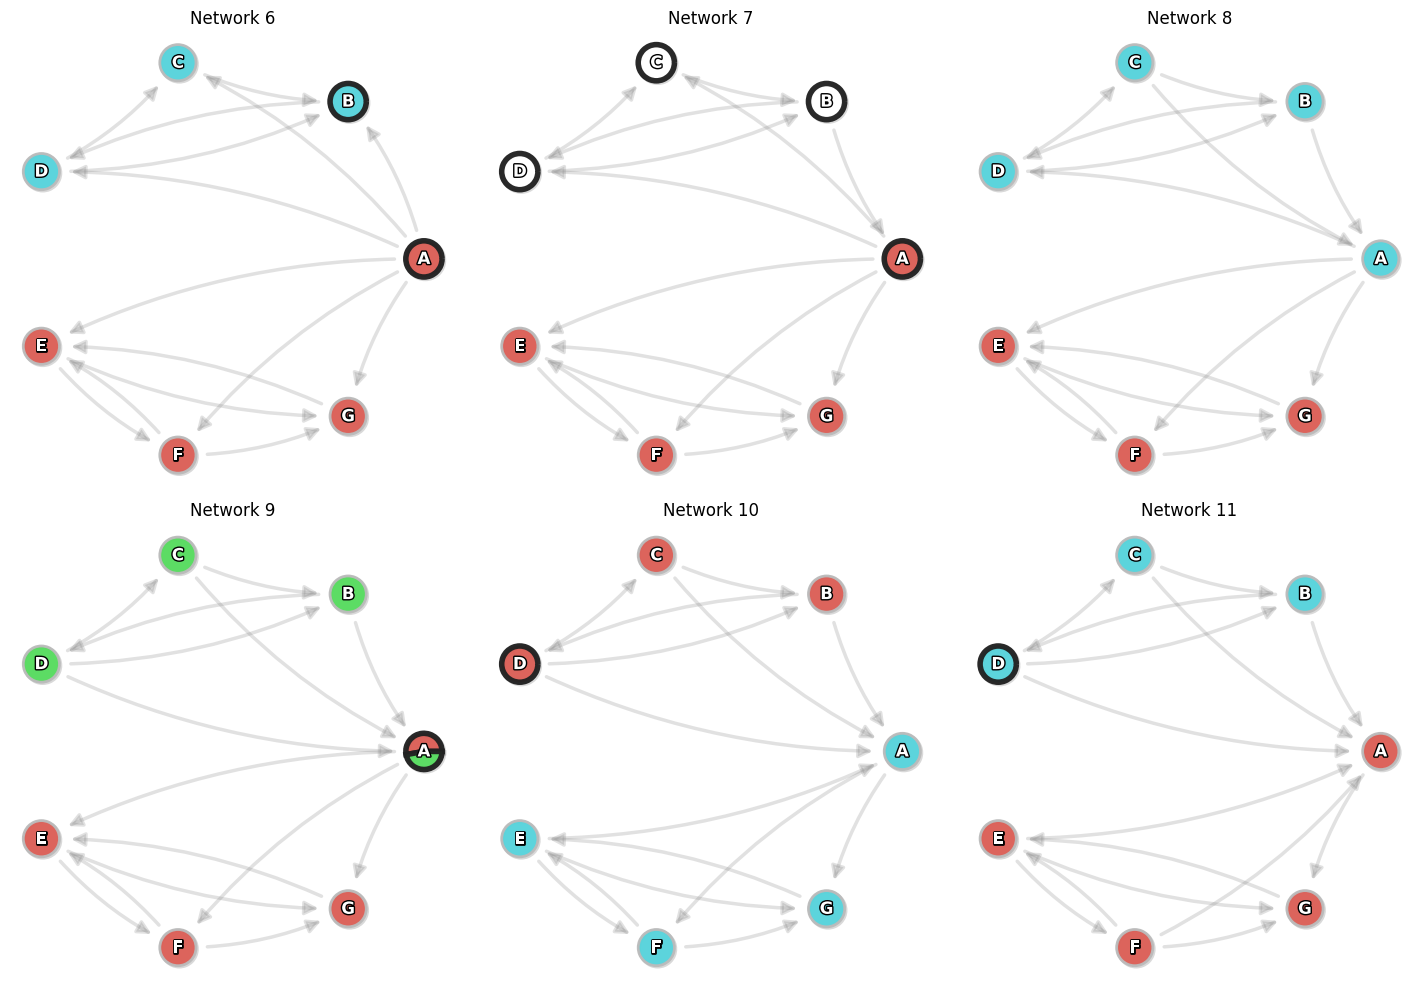

In [5]:
score = "D"

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6, 12):
    number_link_communities, \
        number_node_communities, \
            height_at_maximum = linknode_equivalence_partition(
                score=score,
                link_stats=clustering[idx][2],
                linknode_equivalence=clustering[idx][1].linknode_equivalence
            )

    node_partition = cut_tree_with_validation(clustering[idx][1].Z, number_node_communities)
    node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0

    # NOTE: Node labels as a numpy array
    node_labels = np.array([clustering[0][1].G.nodes[n]["label"] \
                            for n in sorted(clustering[0][1].G.nodes())]
                                )

    # Compute NOCs using the node partition
    nocs_model = linknode.NOCFinder(
        clustering[idx][0], node_partition,
        undirected=False,
        labels=node_labels,
        similarity_index="cosine_similarity",
        tie_policy="include_equal"
    )
    
    # Fit the NOC model using the precomputed link similarity matrices
    nocs_model.fit(
        clustering[idx][1].linksim.source_sim_matrix,
        clustering[idx][1].linksim.target_sim_matrix
    )


     # Create a copy of the graph with transformed edge weights
    Gdist = clustering[idx][0].copy()
    weights = [d['weight'] for u, v, d in Gdist.edges(data=True)]
    max_weight = max(weights) if weights else 1
    for u, v, d in Gdist.edges(data=True):
        d['weight'] = 1 - d['weight'] / max_weight

    pos = nx.kamada_kawai_layout(Gdist)

    # Plot on the corresponding axis
    graph_network_covers(
        clustering[idx][0],
        pos,
        nocs_model.node_cover_partition,
        node_partition,
        nocs_model.single_node_cover_map,
        nocs_model.single_nodes_cover_scores,
        node_labels,
        figsize=(5, 5),
        scale=0.5,
        ax=axes[idx-6]
    )
    axes[idx-6].set_title(f"Network {idx}")

plt.tight_layout()
plt.show()

